# 1. Imports & Create datasets

This notebook aims to use H2O-LLMStudio to build a solution for the H2o.ai Predict the LLM Kaggle competition. Most of the training is done offline and this solution uses the H2O-LLMStudio GUI to do the training. The cfg*.yaml files are core to the solution and should be used as needed.

Before we deep dive into the implementation details, here is a brief look at the solution architecture. We take advantage of Mistral 7B decoder LLM which demonstrates strong performance on many baselines. For this competition, this model performed great in my experiments.

Incase you're curious, my ML logbook is here - <>
Experiment runs on Neptune are here - <>

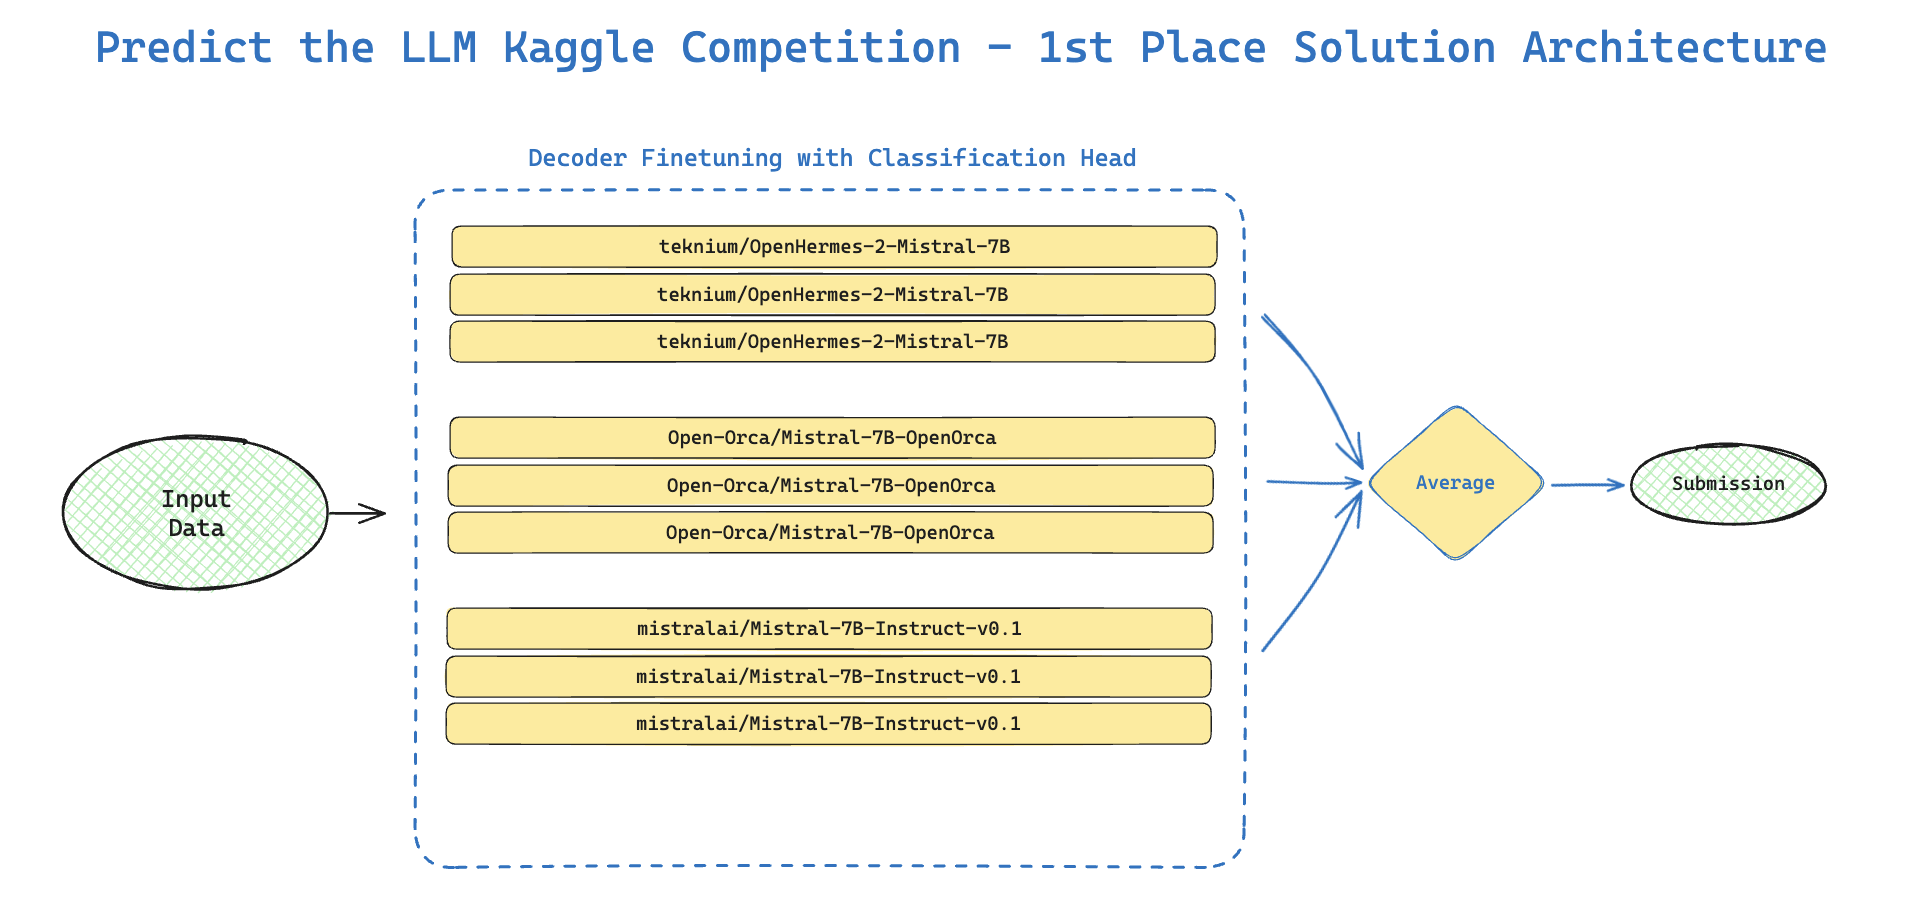

As the first step, let's create datasets compatible with H2O-LLMStudio training.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

from sklearn.model_selection import StratifiedGroupKFold

def softmax(logits):
    exp_scores = np.exp(logits)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [3]:
train = train.fillna('NA')
test = test.fillna('NA')

train['input'] = 'Question: ' + train.Question + '; Answer: ' + train.Response
test['input'] = 'Question: ' + test.Question + '; Answer: ' + test.Response

In [4]:
test['target'] = 0

In [5]:
# Creating datasets for H2O-LLMStudio
train.to_csv("../data/ptl-train.csv", index=False)
test.to_csv("../data/ptl-test.csv", index=False)

! zip ../data/ptl-archive.zip ../data/ptl-train.csv ../data/ptl-test.csv

updating: ../data/ptl-train.csv (deflated 80%)
updating: ../data/ptl-test.csv (deflated 80%)


# 2. Training

With the dataset we just created, we build 9 models - 3 seeds for 3 different backbones as illustrated in the picture below.

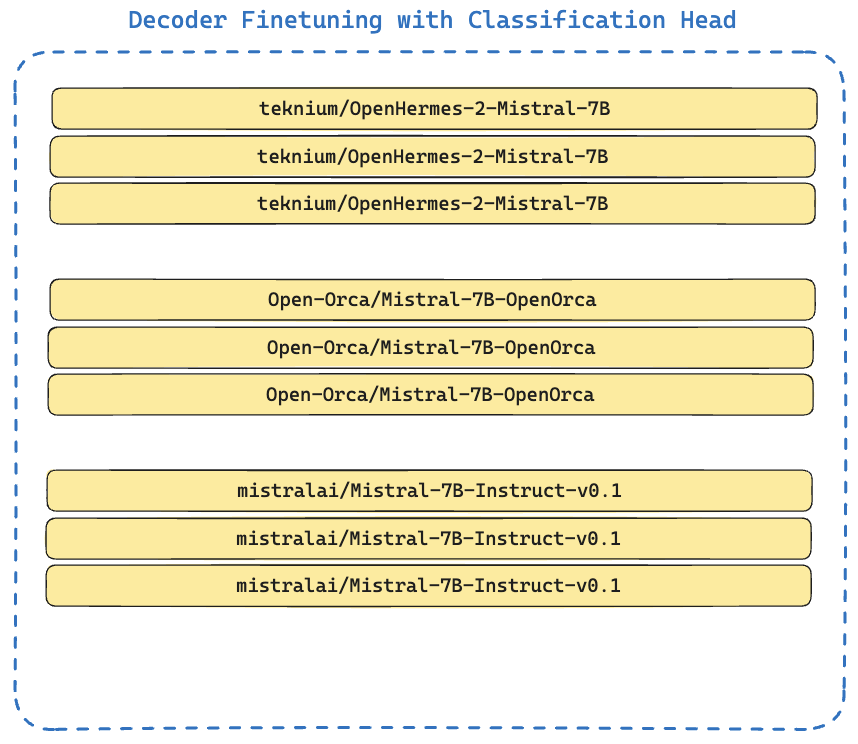

For each experiment, use the corresponding yaml file provided in the attached dataset.

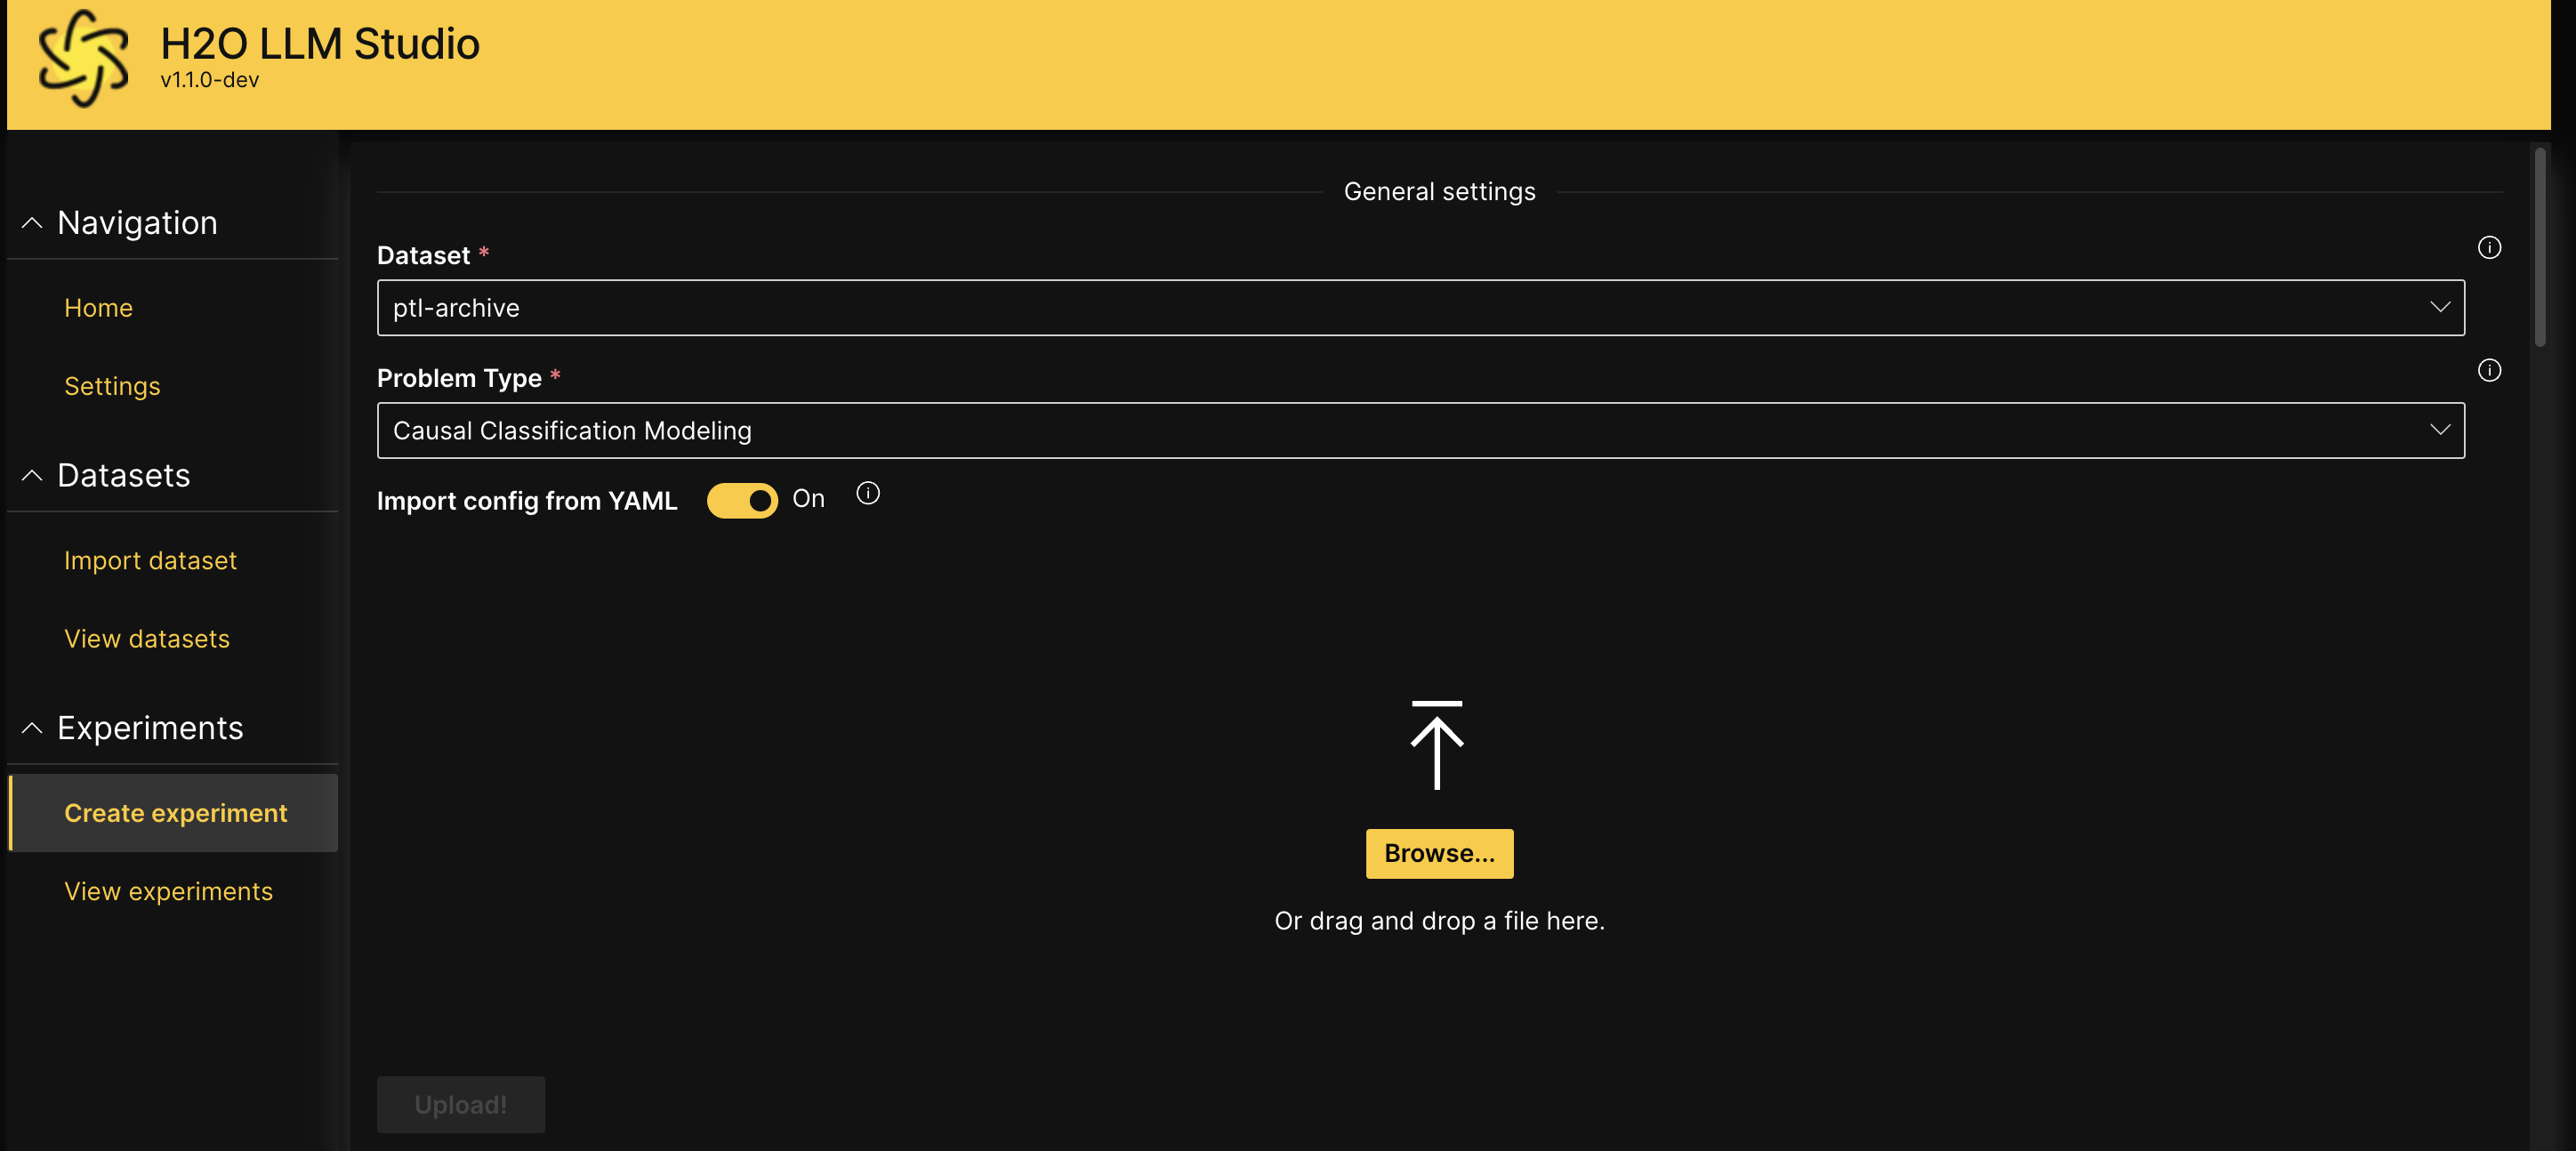

As H2O-LLMStudio provides a nice GUI, this can be done via a few clicks!

# 3. Decoder Submission

Once the models are built, the predictions can be downloaded to the downloads directory. Once all the 9 prediction files are downloaded, we can do a straight average between each of these models.

In [6]:
model_path = Path("/h2o-llmstudio/output/user/")

# teknium/OpenHermes-2-Mistral-7B # 0.762
p1 = pd.read_pickle(model_path / "preds_groovy-crab/validation_raw_predictions.pkl")
p2 = pd.read_pickle(model_path / "preds_sociable-marten/validation_raw_predictions.pkl")
p3 = pd.read_pickle(model_path / "preds_fair-gerbil/validation_raw_predictions.pkl")

probabilities1 = np.mean([softmax(p1['logits']),
                         softmax(p2['logits']),
                         softmax(p3['logits'])], axis=0) # LB: 0.665

# Open-Orca/Mistral-7B-OpenOrca
p1 = pd.read_pickle(model_path / "preds_topaz-starling/validation_raw_predictions.pkl")
p2 = pd.read_pickle(model_path / "preds_ethereal-swift/validation_raw_predictions.pkl")
p3 = pd.read_pickle(model_path / "preds_astonishing-toucan/validation_raw_predictions.pkl")

probabilities2 = np.mean([softmax(p1['logits']),
                         softmax(p2['logits']),
                         softmax(p3['logits'])], axis=0)

# mistralai/Mistral-7B-Instruct-v0.1
p1 = pd.read_pickle(model_path / "preds_berserk-vicugna/validation_raw_predictions.pkl")
p2 = pd.read_pickle(model_path / "preds_auburn-urchin/validation_raw_predictions.pkl")
p3 = pd.read_pickle(model_path / "preds_flawless-saluki/validation_raw_predictions.pkl")

probabilities3 = np.mean([softmax(p1['logits']),
                         softmax(p2['logits']),
                         softmax(p3['logits'])], axis=0)

probabilities = np.mean([probabilities1, probabilities2, probabilities3], axis=0)
sample_submission.loc[:,'target_0': 'target_6'] = probabilities
sample_submission.to_csv("submission.csv", index=False) # LB: 0.623

This submission should give you 0.623 on the leaderboard. Due to multiple backbones and seed averaging, the logloss substantially improves.

To further improve the score, we need to run this submission via Kha Vo's optimizer :)

# 4. Generate OOF Folds

For second stage models where Kha Vo found optimal coefficients, we need OOF predictions. Instead of generating OOF predictions for all 9 models, we decided to do it with 1 backbone and 3 seeds for time/cost purposes. We use H2O-LLMStudio to do this as well.

As the train dataset contains 7 QA records for each question, for effective leak-free cross validation, we need to do groupkfold.

In [7]:
question_group_dict = dict(zip(train['Question'].unique(), range(len(train['Question'].unique()))))
train['group'] = train['Question'].map(question_group_dict)
test['group'] = -1
test['target'] = 0
test = test[train.columns]
train

,Question,Response,target,input,group
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3,Question: Explain the concept of coevolution.;...,0
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4,Question: Is it possible that recurring fever ...,1
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1,Question: Evaluate the expression 3!; Answer: ...,2
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3,Question: What are the roles of different type...,3
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3,Question: What is the role of gene flow in pop...,4
...,...,...,...,...,...
3971,You will always find me in the past. I can be ...,Please select one of the options from the tabl...,0,Question: You will always find me in the past....,68
3972,To give me to someone i don’t belong to is cow...,________________________________. (20 points),0,Question: To give me to someone i don’t belong...,507
3973,Could severe abdominal pain and vomiting be in...,Abdominal pain and vomiting can indeed be symp...,1,Question: Could severe abdominal pain and vomi...,558
3974,How can I increase my productivity at work or ...,1. Prioritize tasks: Make a to-do list with th...,1,Question: How can I increase my productivity a...,152


In [8]:
n_splits = 5

groups = train['group']
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
sgkf.get_n_splits(train['input'], train['target'])
print(sgkf)

val_indices = []

val_scores = []

for i, (train_index, test_index) in enumerate(sgkf.split(train['input'], train['target'], groups)):
    tr = train.loc[train_index]
    val = train.loc[test_index]
    print(tr.shape, val.shape)
    val = pd.concat([val, test], axis=0).reset_index(drop=True) # if you are using H2O LLM Studio, use this line. Otherwise, comment this line.
    

    val_indices.append(test_index)

    tr.to_csv(f"../data/train-fold{i}.csv", index=False)
    val.to_csv(f"../data/val-fold{i}.csv", index=False)
    
! zip ../data/ptl-train-val-test.zip ../data/train-fold* ../data/val-fold*

StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
(3178, 5) (798, 5)
(3178, 5) (798, 5)
(3178, 5) (798, 5)
(3185, 5) (791, 5)
(3185, 5) (791, 5)
  adding: ../data/train-fold0.csv (deflated 80%)
  adding: ../data/train-fold1.csv (deflated 80%)
  adding: ../data/train-fold2.csv (deflated 80%)
  adding: ../data/train-fold3.csv (deflated 80%)
  adding: ../data/train-fold4.csv (deflated 80%)
  adding: ../data/val-fold0.csv (deflated 80%)
  adding: ../data/val-fold1.csv (deflated 80%)
  adding: ../data/val-fold2.csv (deflated 80%)
  adding: ../data/val-fold3.csv (deflated 80%)
  adding: ../data/val-fold4.csv (deflated 81%)


# 5. Generate OOF Predictions

Just like how we trained our models using H2O-LLMStudio earlier, for OOF predictions, we will train models similarly.

For each of the 5 folds we created earlier, we run 3 models with 3 different seeds. This results in 15 models to create train out of fold predictions and test predictions. Finally, we average the predictions for second stage training.

As the next step, run the 15 cfg-oof-* yaml files to generate 15 prediction pickle files.

The dataset here is ptl-train-val-test that contains
- train-fold*.csv
- val-fold*.csv

generated in the previous step.

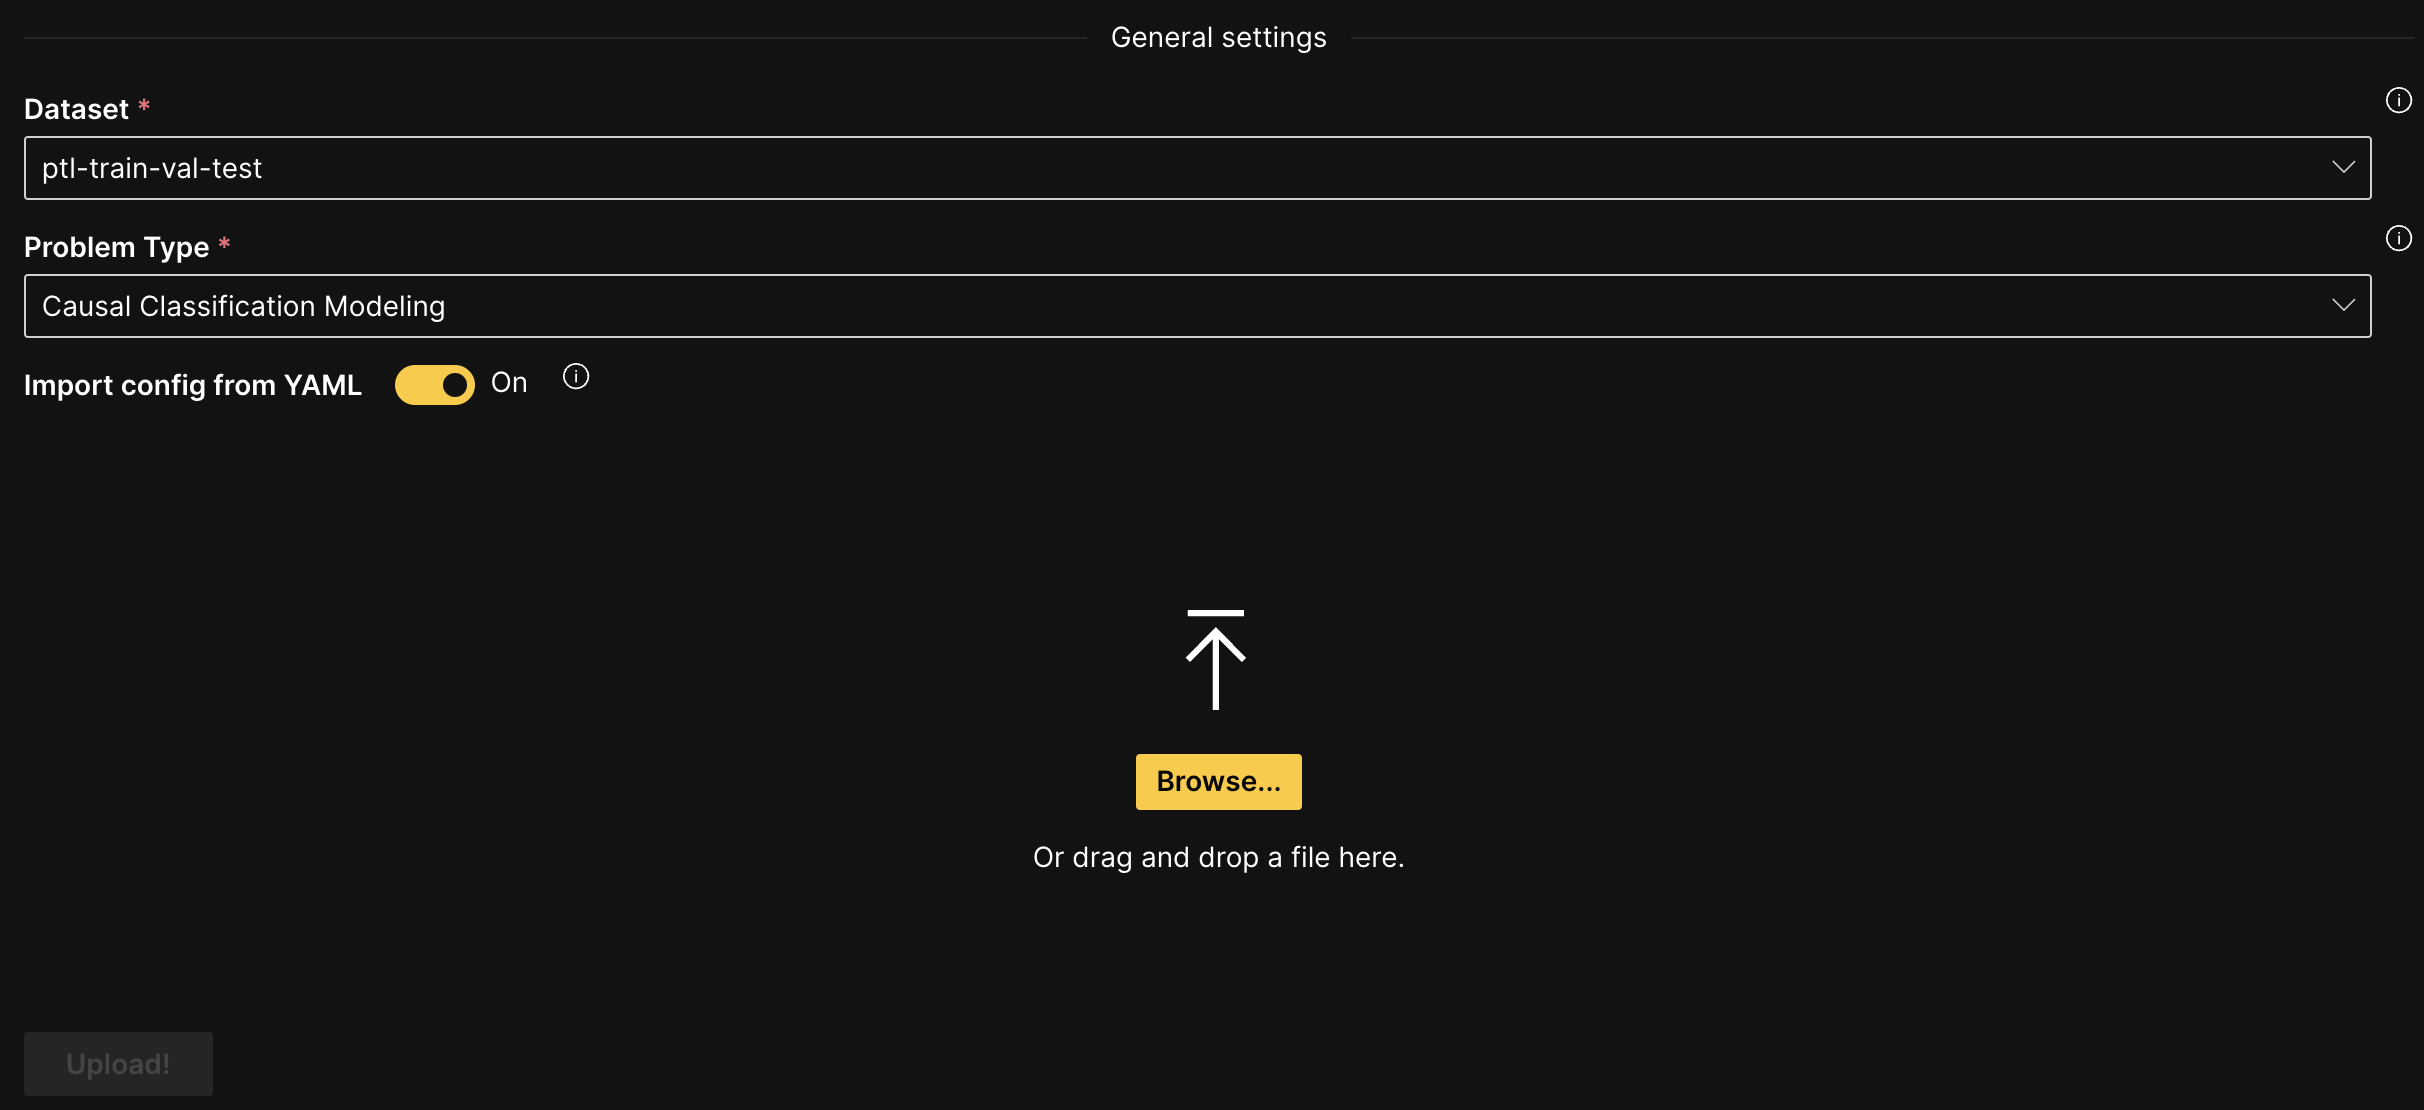

# 6. Combine OOF predictions for second stage

In [9]:
oof_preds_train = np.zeros((train.shape[0], train['target'].nunique()))
oof_preds_test = np.zeros((test.shape[0], train['target'].nunique()))

# random seed run 1
for fold in [0,1,2,3,4]:
    oof_fold_logits = pd.read_pickle(f"../h2o-llmstudio/output/user/folds-{fold}/validation_raw_predictions.pkl")['logits']
    oof_fold_probabilities = softmax(oof_fold_logits) # converting logits to probabilities
    
    val_fold = pd.read_csv(f"../data/val-fold{fold}.csv")
    for i in range(7):
        # split val and test
        val_index = val_fold[val_fold['group'] > -1].index
        test_index = val_fold[val_fold['group'] == -1].index

        oof_preds_train[val_indices[fold], i] += oof_fold_probabilities[val_index,i]
        oof_preds_test[:, i] += oof_fold_probabilities[test_index,i]

# random seed run 2
for fold in [10,11,12,13,14]:
    oof_fold_logits = pd.read_pickle(f"../h2o-llmstudio/output/user/folds-{fold}/validation_raw_predictions.pkl")['logits']
    oof_fold_probabilities = softmax(oof_fold_logits) # converting logits to probabilities
    
    val_fold = pd.read_csv(f"../data/val-fold{fold-10}.csv")
    for i in range(7):
        # split val and test
        val_index = val_fold[val_fold['group'] > -1].index
        test_index = val_fold[val_fold['group'] == -1].index

        oof_preds_train[val_indices[fold-10], i] += oof_fold_probabilities[val_index,i]
        oof_preds_test[:, i] += oof_fold_probabilities[test_index,i]

# random seed run 3
for fold in [20,21,22,23,24]:
    oof_fold_logits = pd.read_pickle(f"../h2o-llmstudio/output/user/folds-{fold}/validation_raw_predictions.pkl")['logits']
    oof_fold_probabilities = softmax(oof_fold_logits) # converting logits to probabilities
    
    val_fold = pd.read_csv(f"../data/val-fold{fold-20}.csv")
    for i in range(7):
        # split val and test
        val_index = val_fold[val_fold['group'] > -1].index
        test_index = val_fold[val_fold['group'] == -1].index

        oof_preds_train[val_indices[fold-20], i] += oof_fold_probabilities[val_index,i]
        oof_preds_test[:, i] += oof_fold_probabilities[test_index,i]

oof_preds_train = oof_preds_train / 3.0 # dividing by 3 since 3 seeds
oof_preds_test = oof_preds_test / 15.0 # diving by 15 since 3 seeds x 5 folds

In [10]:
for i in range(7):
    train[f'target_{i}'] = oof_preds_train[:,i]

train.to_csv("../data/train-oofpredictions.csv", index=False)

for i in range(7):
    test[f'target_{i}'] = oof_preds_test[:,i]

test.to_csv("../data/test-oofpredictions.csv", index=False)